![](https://cdn.shopify.com/s/files/1/0528/8266/9745/files/aa9ba33a428bcfb93a45b4a44e5019d3.jpg?v=1676085807)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.names
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/Index
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/PS4 E4 original abalone dataset from UCI.csv
/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


## **Your Goal**: Predict the age of abalone from various physical measurements.

- <font face="Bahnschrift Condensed" style="font-size: 14pt; color: #3EB489">
Predicting the age of abalone from physical measurements. The age of
abalone is determined by cutting the shell through the cone, staining it,
and counting the number of rings through a microscope -- a boring and
time-consuming task.  Other measurements, which are easier to obtain, are
used to predict the age.  Further information, such as weather patterns
and location (hence food availability) may be required to solve the problem.
</font>
  
  
- <font face="Bahnschrift Condensed" style="font-size: 14pt; color: #3EB489">
From the original data examples with missing values were removed (the
majority having the predicted value missing), and the ranges of the
continuous values have been scaled for use with an ANN (by dividing by 200).
</font>

![](https://www.kaggle.com/competitions/72489/images/header)

## <font face="Bahnschrift Condensed" style="font-size: 14pt; color: #3EB489">Abalone Dataset Description</font>

**<span style="color: orange;">Sex:** Represents the gender of the abalone, categorized as male (M), female (F), or infant (I).
  
**<span style="color: orange;">Length:** Denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.
  
**<span style="color: orange;">Diameter:** Represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.
  
**<span style="color: orange;">Height:** Signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.
  
**<span style="color: orange;">Whole Weight:** Indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.
  
**<span style="color: orange;">Shucked Weight:** Represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.
  
**<span style="color: orange;">Viscera Weight:** Signifies the weight of the abalone gut after bleeding, measured in grams. It provides insights into the weight of the internal organs of the abalone.
  
**<span style="color: orange;">Shell Weight:** Represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.
  
**<span style="color: orange;">Rings:** Signifies the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

# <span style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 50px;">Table of Contents</span>

- [Import libraries](#1)
- [Open data files](#2)
- [Show first 5 lines of train data](#3)
- [Compare original train and competition train](#3.1)
- [Concatenate original train with competition train](#3.2)
- [Figure out how much duplicates in data](#3.3)
- [Remove duplicates from data](#3.4)
- [Shapes of train and test data](#4)
- [Display descriptive statistics of train data](#5)
- [Check the number of gaps for each feature](#6)
- [One-hot encoding](#7.3)
- [More plots](#7.4)
- [Display histograms of distribution](#8)
- [Let's count target of train data](#9)
- [Transform the data with log1p](#10)
- [Feature importance](#10.2)
- [Build a heat map of correlations](#11)
- [Define base models with tuned hyperparameters](#12)
- [Defining the meta-model with tuned hyperparameters](#13)
- [Creating and fitting the stacking model](#14)
- [Predict validation set and calculate metrics score](#15)
- [Predict the test data](#16)
- [Build DataFrame and make submission](#17)
- [Save the model into pickle file](#18)

<a id='1'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🌊 Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

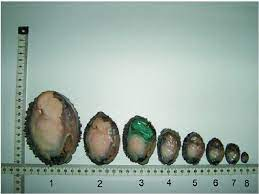

<a id='2'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐚 Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data', header=None)

train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

<a id='3'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">⛵ Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


### Target feature is 'Rings'

<a id='3.1'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍤 Compare original train and competition train</span>

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(4177, 9)


[0, 1, 2, 3, 4, 5, 6, 7, 8]

### In original data there is no columns in file .data

In [7]:
# Save original dataset into .csv
original_train.columns = train.columns[1:]
original_train.to_csv('🌊🐚⛵🍤 PS4 E4 original abalone dataset from UCI.csv', index=False)
original_train.tail()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


In [8]:
print(train.shape)
train.columns.tolist()

(90615, 10)


['id',
 'Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

<a id='3.2'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🌊 Concatenate original train with competition train

In [9]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [10]:
train = pd.concat(objs=[train, original_train])
train.shape

(94792, 9)

<a id='3.3'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐚 Figure out how much duplicates in data

In [11]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


#### There are no any duplicats in data but if they would be presented use code below

<a id='3.4'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">⛵ Remove duplicates from data

In [12]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
print(len(train_duplicates))

0


<a id='4'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐟 Shapes of train and test data</span>

In [13]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (94792, 9)
Test data: (60411, 8)

Train data consists of 61.08% of all observations
Test data consists of 38.92% of all observations


![](https://www.altnaturals.com/cdn/shop/products/All-AbaloneSizes-Small_1500x411.jpg?v=1637679377)

<a id='5'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐠 Display descriptive statistics of train data</span>

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,94792.0,0.517402,0.118308,0.0750,0.4450,0.5450,0.6000,0.8150
Diameter,94792.0,0.401952,0.098088,0.0550,0.3450,0.4250,0.4700,0.6500
Height,94792.0,0.135643,0.038193,0.0000,0.1100,0.1400,0.1600,1.1300
Whole weight,94792.0,0.790785,0.459231,0.0020,0.4195,0.7995,1.0725,2.8255
Whole weight.1,94792.0,0.341597,0.205267,0.0010,0.1775,0.3300,0.4645,1.4880
Whole weight.2,94792.0,0.169914,0.101334,0.0005,0.0865,0.1660,0.2330,0.7600
Shell weight,94792.0,0.226468,0.130639,0.0015,0.1200,0.2250,0.3050,1.0050
Rings,94792.0,9.707233,3.178704,1.0000,8.0000,9.0000,11.0000,29.0000


<a id='6'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐡 Check the number of gaps for each feature</span>

In [15]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64



TEST data

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64


#### There is no any gaps in the data

![](https://www.asnailsodyssey.com/views/images/119/Geiger&Owen2019.jpg)

<a id='7'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦈 Data types of training set</span>

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


#### Sex feature is object, so we have to convert in into numeric

<a id="7.2"></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦭 Remove duplicates from train data</span>

In [17]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
duplicates = train[train.duplicated()]
len(duplicates)

0

<a id="7.3"></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍢 One-hot encoding

In [18]:
X = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

<a id='8'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦞 Display histograms of distribution</span>

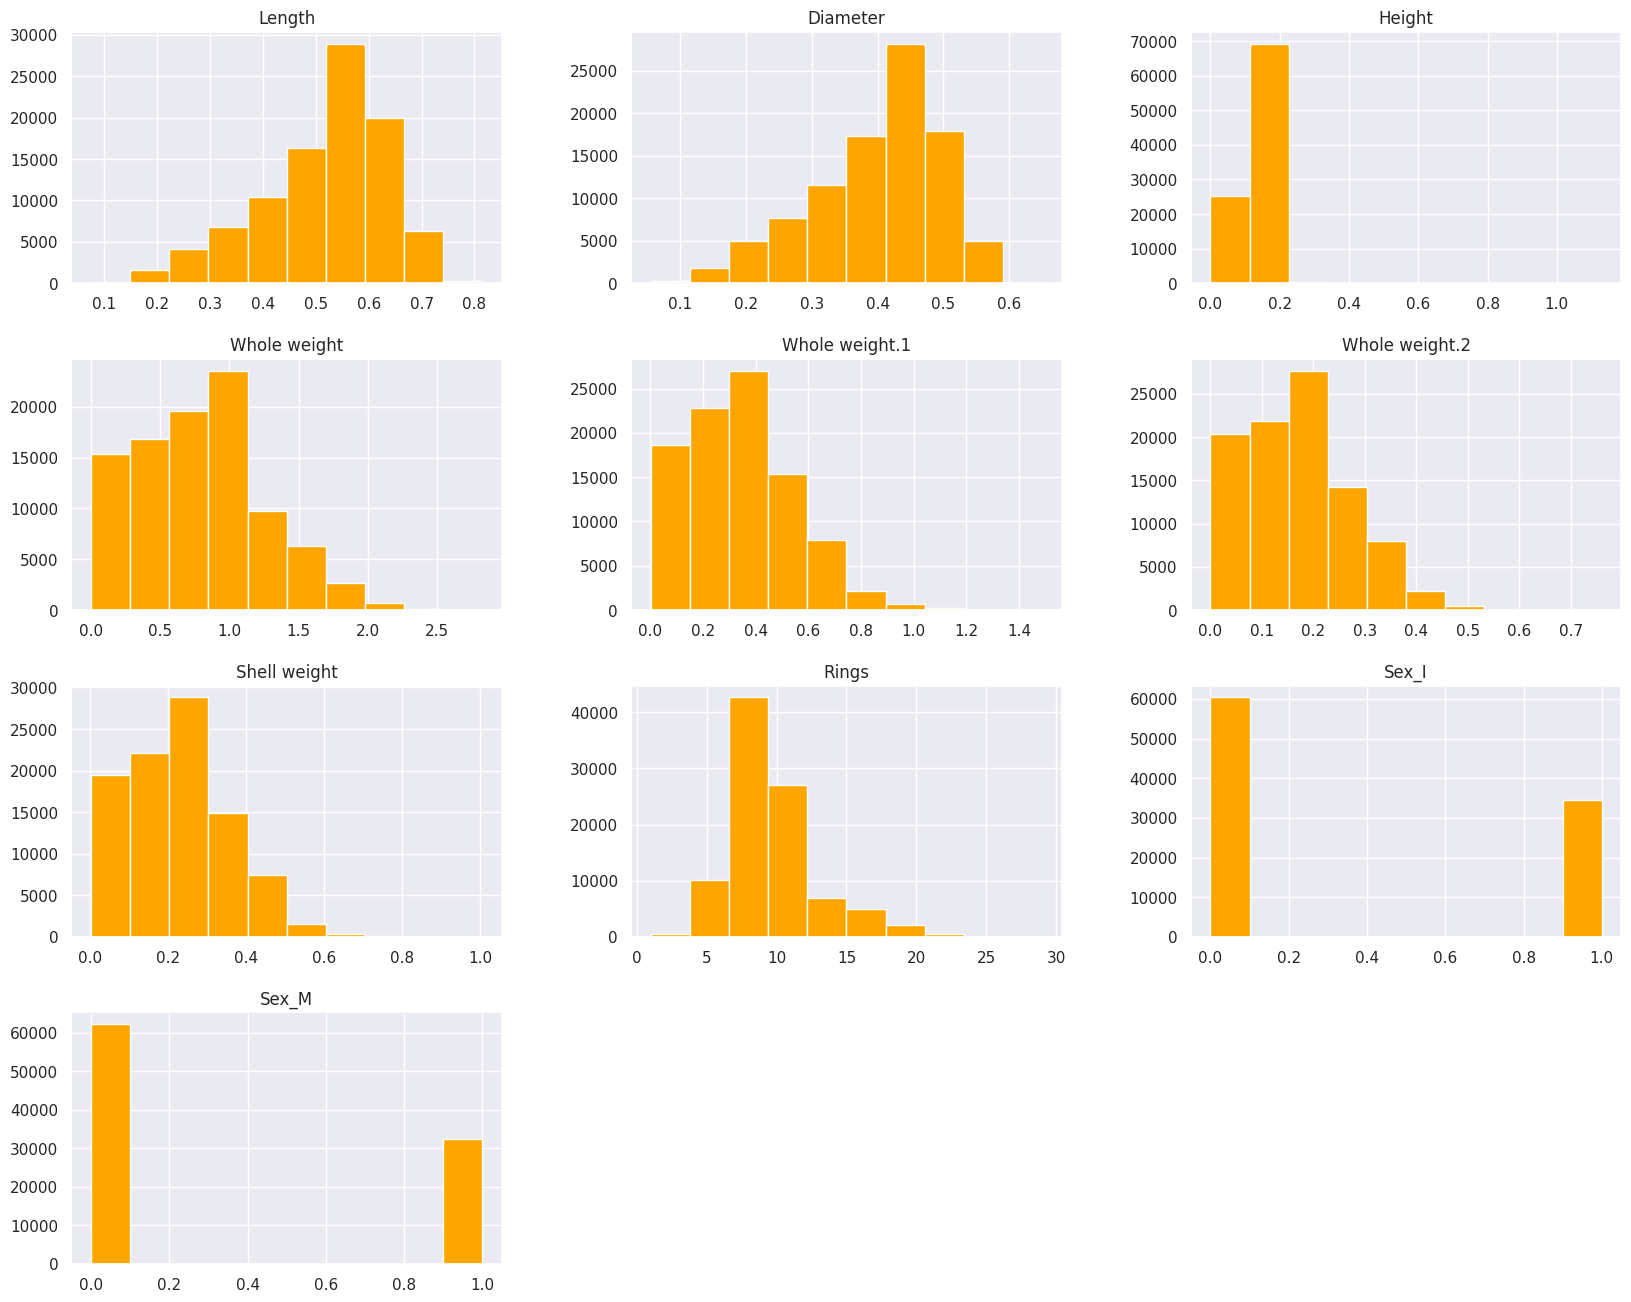

In [19]:
sns.set(rc={'figure.figsize': (20, 16)})
X.hist(color='orange');

<a id='9'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦐 Let's count target of train data</span>

In [20]:
print(f'{train.Rings.value_counts()}\n\n')
print(train.Rings.value_counts() / train.shape[0])

Rings
9     18154
8     15067
10    13098
7      9399
11     8894
6      5670
12     4986
13     4277
5      2977
14     2633
15     2175
16     1506
4      1459
17     1233
18      890
19      671
20      533
3       401
21      269
23      189
22      114
27       43
24       31
2        30
1        26
29       25
25       23
26       19
Name: count, dtype: int64


Rings
9     0.191514
8     0.158948
10    0.138176
7     0.099154
11    0.093826
6     0.059815
12    0.052599
13    0.045120
5     0.031406
14    0.027777
15    0.022945
16    0.015887
4     0.015392
17    0.013007
18    0.009389
19    0.007079
20    0.005623
3     0.004230
21    0.002838
23    0.001994
22    0.001203
27    0.000454
24    0.000327
2     0.000316
1     0.000274
29    0.000264
25    0.000243
26    0.000200
Name: count, dtype: float64


<a id='10'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦑 Transorm the data with MinMax</span>

In [21]:
# Split the train data into X and y
X = X.drop(['Rings'], axis=1)
y = train.Rings

# for column in X.columns.tolist():
#     X[column] = X[column].apply(lambda x: (x - X[column].min()) / (X[column].max() - X[column].min()))

# # Transform test data
# for column in test.columns.tolist():
#     test[column] = test[column].apply(lambda x: (x - test[column].min()) / (test[column].max() - test[column].min()))
    
# X.hist(color='LightSeaGreen');

![](https://d3h1lg3ksw6i6b.cloudfront.net/media/image/2020/09/24/a40d8dea2d924e0aa7cdb644beffe934_abalone+dish.jpg)

<a id='10.2'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">💦 Feature importance</span>

CPU times: user 49.9 s, sys: 439 ms, total: 50.4 s
Wall time: 50.3 s


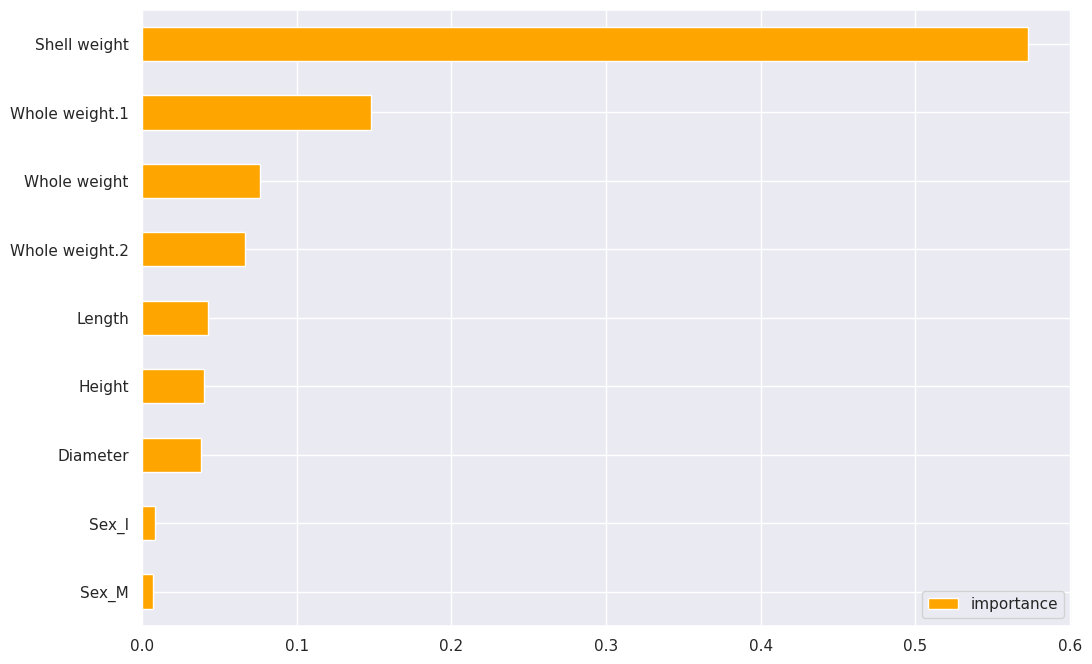

In [22]:
%%time
# I figured out best hyperparameters previously
best_forest = RandomForestRegressor(
    random_state=27,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='orange');

<a id='11'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🌊 Build a heat map of correlations</span>

In [23]:
X.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Sex_I', 'Sex_M'],
      dtype='object')

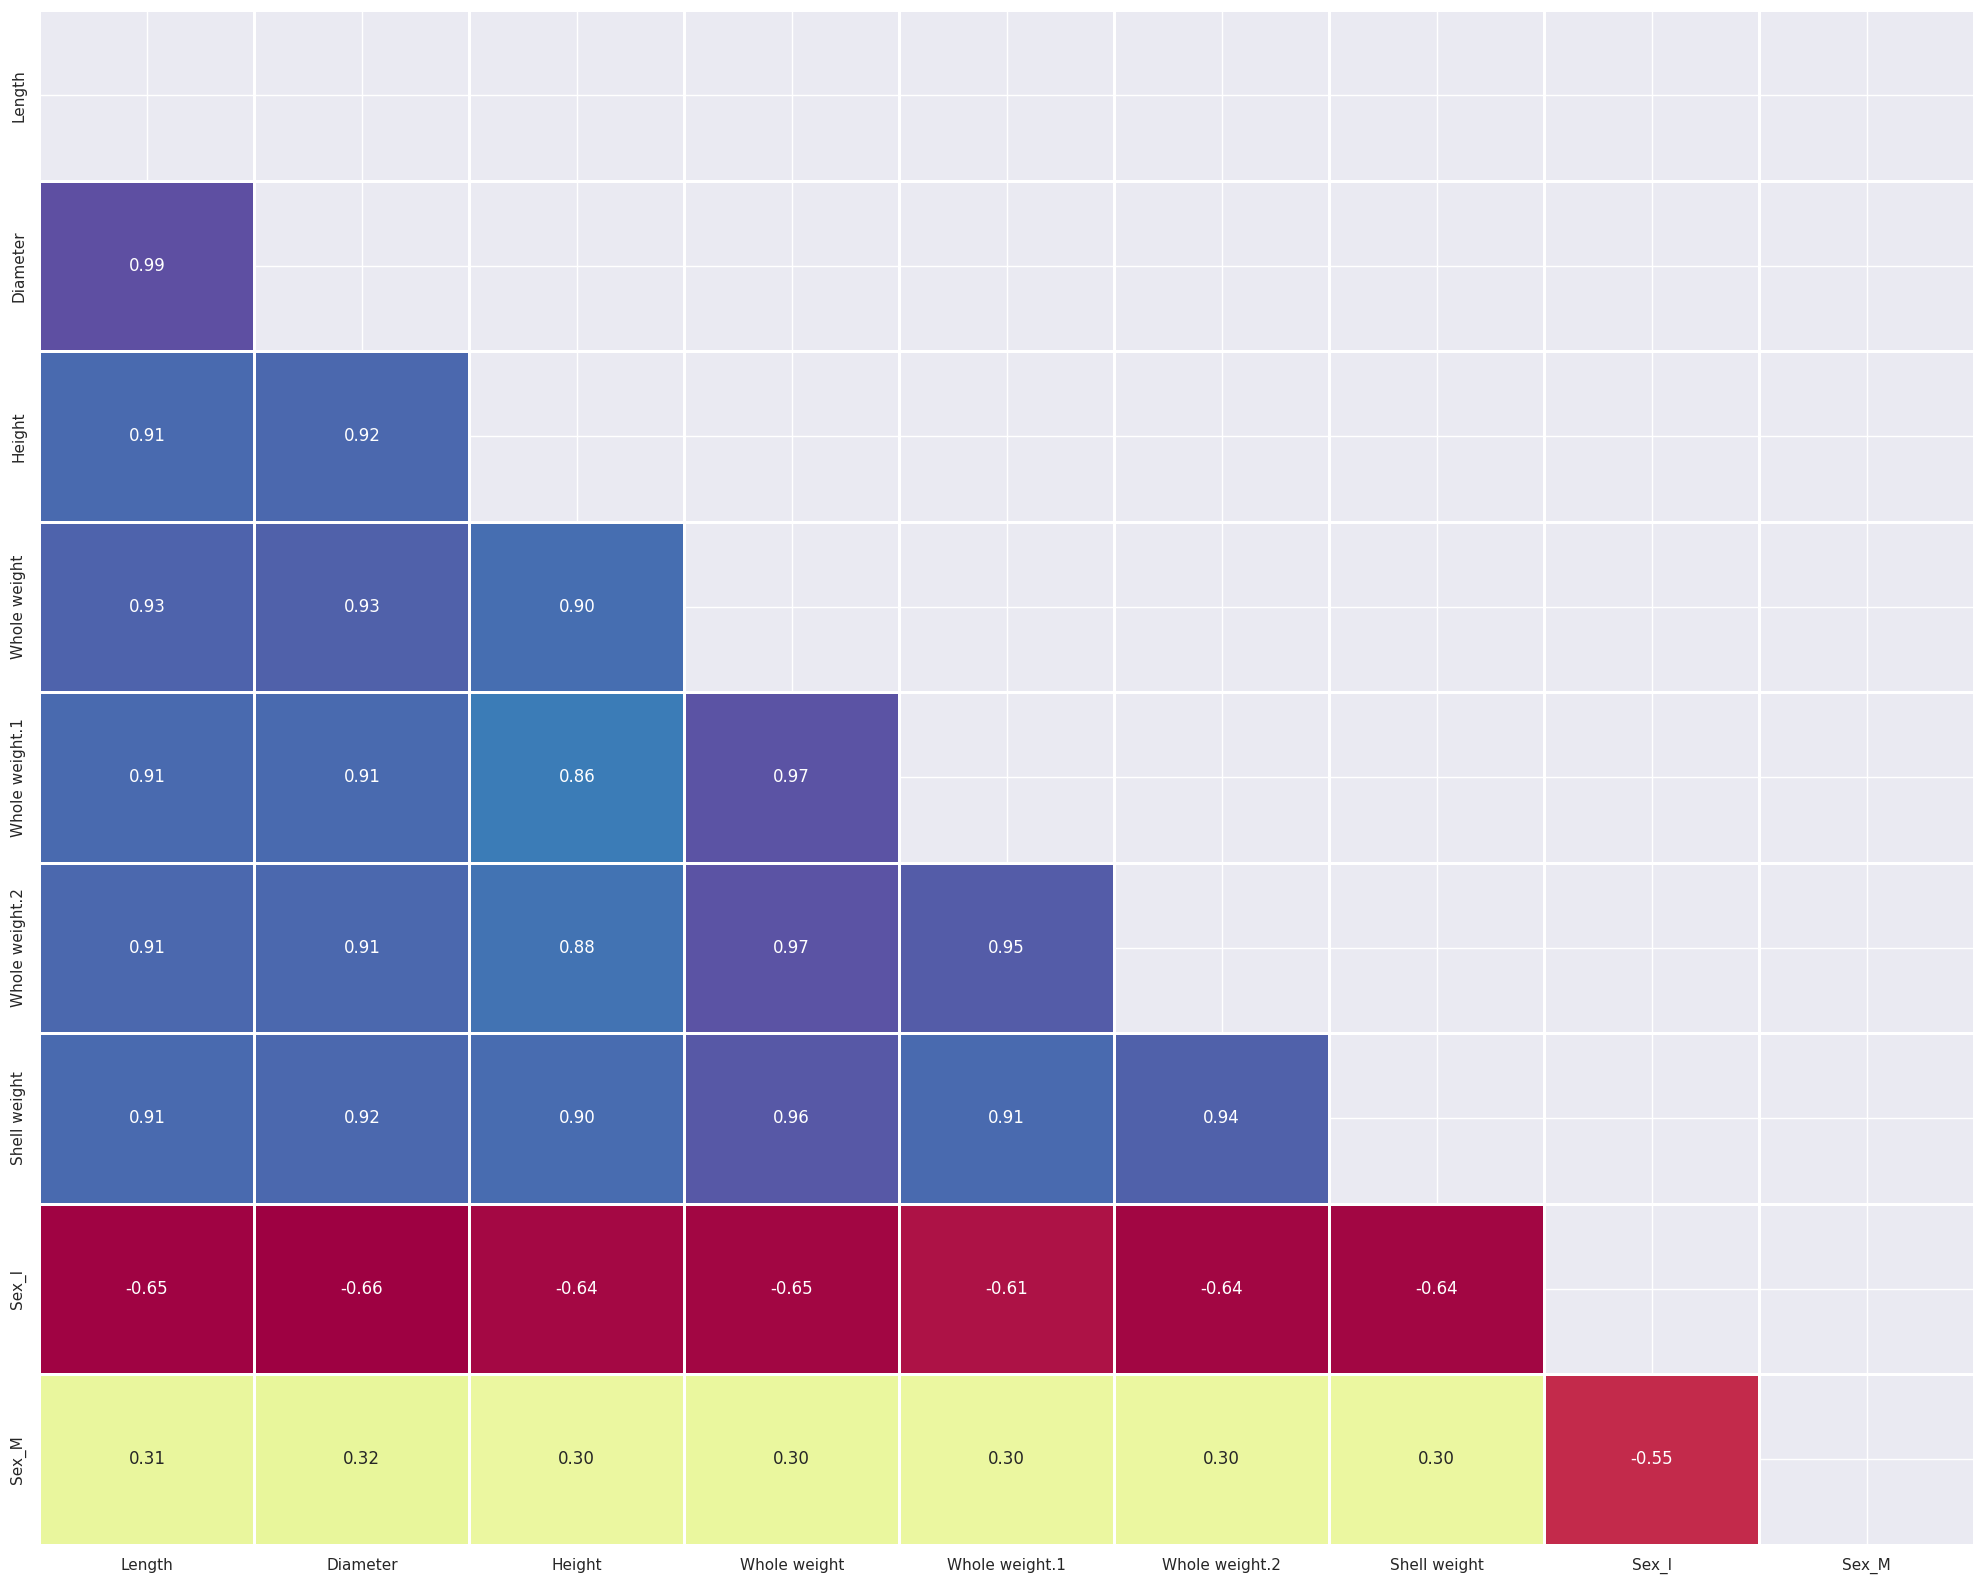

In [24]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

#### Let's drop highly correlated features and look on the metric

In [25]:
X = X.drop(['Diameter'], axis=1)
test = test.drop(['Diameter'], axis=1)

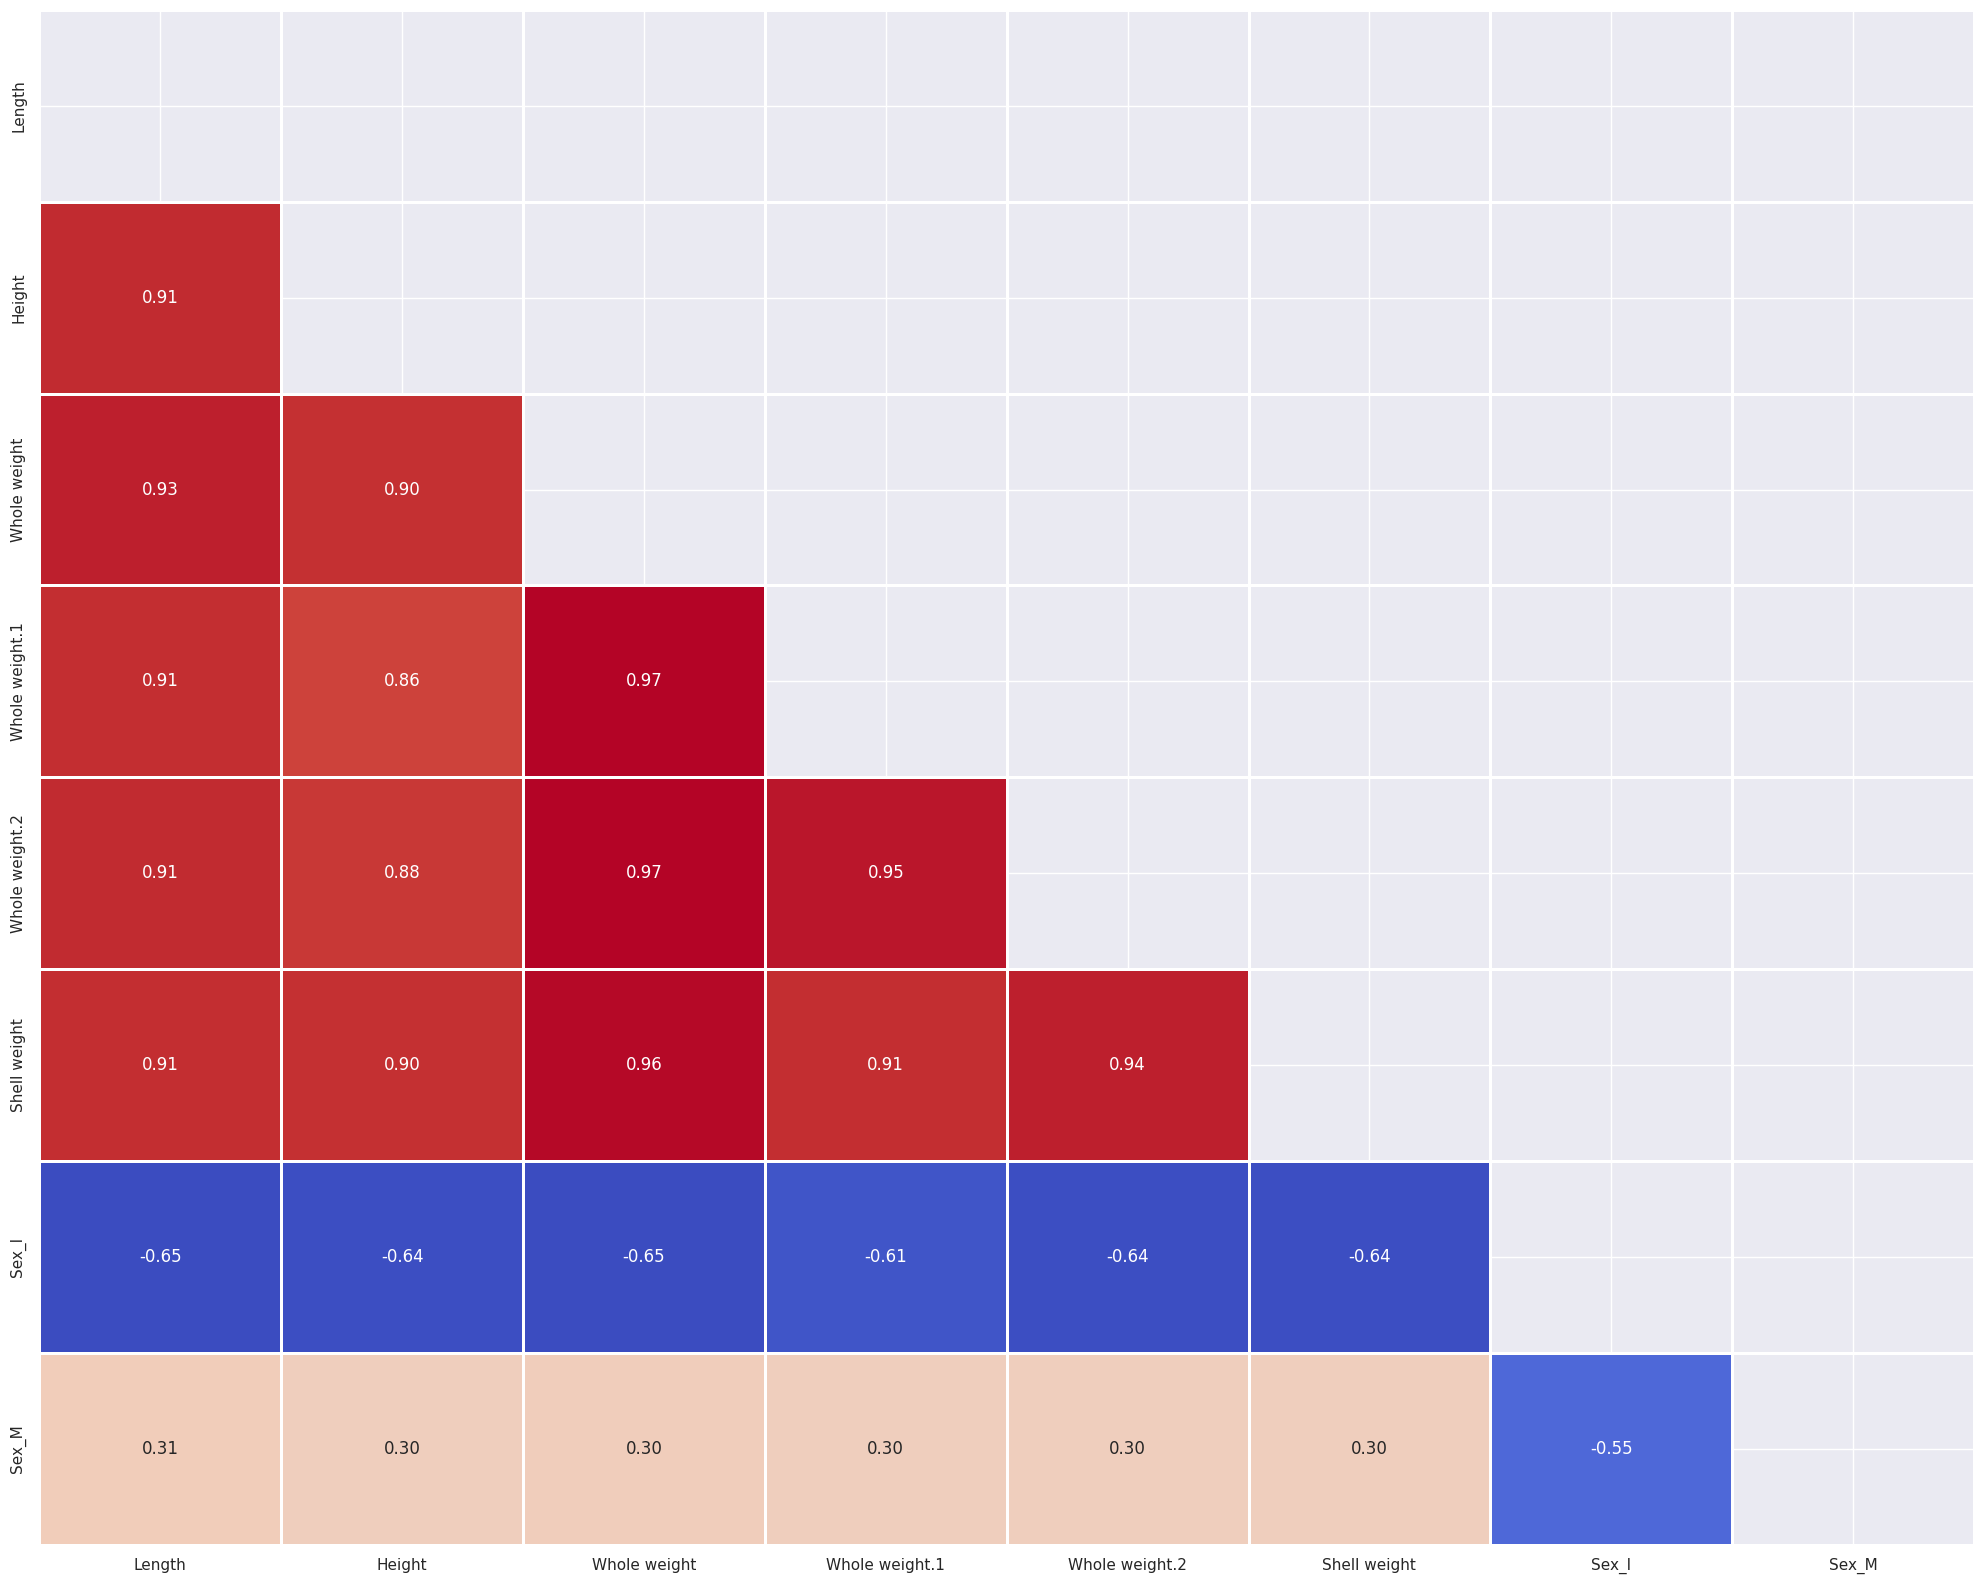

In [26]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='coolwarm', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

<a id='12'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐚 Define base models</span>

In [27]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

![](https://www.foodrepublic.com/img/gallery/what-exactly-is-abalone-and-how-do-you-eat-it/l-intro-1695291935.jpg)

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px;">Random Forest with Optuna</p>

In [28]:
# %%time
# def objective(trial):
#     model = RandomForestRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
# #         criterion=trial.suggest_categorical("criterion", ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']),
#         min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         min_samples_split=trial.suggest_int("min_samples_split", 2, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  10
Best trial:
  Value:  0.164014686713176
  Params: 
    n_estimators: 544
    min_samples_leaf: 60
    max_depth: 8
    min_samples_split: 13

CPU times: user 6min 35s, sys: 276 ms, total: 6min 35s
Wall time: 6min 35s
"""

'\nNumber of finished trials:  10\nBest trial:\n  Value:  0.164014686713176\n  Params: \n    n_estimators: 544\n    min_samples_leaf: 60\n    max_depth: 8\n    min_samples_split: 13\n\nCPU times: user 6min 35s, sys: 276 ms, total: 6min 35s\nWall time: 6min 35s\n'

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">XGBoost with Optuna</p>

In [29]:
# %%time
# def objective(trial):
#     model = XGBRegressor(
#         max_depth=trial.suggest_int('max_depth', 1, 100),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         n_estimators=trial.suggest_int('n_estimators', 50, 1000),
#         min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
#         gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         use_label_encoder=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     try:
#         return np.sqrt(mean_squared_log_error(y_test, y_pred))
#     except Exception as e:
#         print(e)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  1
Best trial:
  Value:  0.1775845058982026
  Params: 
    max_depth: 43
    learning_rate: 0.42576257222865277
    n_estimators: 749
    min_child_weight: 9
    gamma: 1.1669337024772915e-05
    subsample: 0.9097315662154742
    colsample_bytree: 0.6114890625963008
    reg_alpha: 4.761254082318455e-07
    reg_lambda: 0.008602430632882225

CPU times: user 24.5 s, sys: 667 ms, total: 25.2 s
Wall time: 25.2 s
"""

'\nNumber of finished trials:  1\nBest trial:\n  Value:  0.1775845058982026\n  Params: \n    max_depth: 43\n    learning_rate: 0.42576257222865277\n    n_estimators: 749\n    min_child_weight: 9\n    gamma: 1.1669337024772915e-05\n    subsample: 0.9097315662154742\n    colsample_bytree: 0.6114890625963008\n    reg_alpha: 4.761254082318455e-07\n    reg_lambda: 0.008602430632882225\n\nCPU times: user 24.5 s, sys: 667 ms, total: 25.2 s\nWall time: 25.2 s\n'

In [30]:
# %%time
# # Searching for best parameters of XGBoost
# from sklearn.model_selection import RandomizedSearchCV

# xgb_regressor = XGBRegressor(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 100, 4),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=xgb_parameters, n_iter=20, n_jobs=-1, cv=5, verbose=4, random_state=27)
# xgb_random_search.fit(X_val, y_val)
# print(f'Best params: {xgb_random_search.best_params_}')

"""
Best params: {'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}
"""

"\nBest params: {'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}\n"

#### I found that XGBoost in this competition can't work with negative targets when it is looking for model that fitting with metrics

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">CatBoost with Optuna</p>

In [31]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 4, 16),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  20
Best trial:
  Value:  0.27250015755480833
  Params: 
    iterations: 101
    learning_rate: 0.0010172906333606835
    colsample_bylevel: 0.4796381789116622
    min_data_in_leaf: 42
    depth: 13
    l2_leaf_reg: 2.895211427077531e-08

CPU times: user 18min 10s, sys: 9min 21s, total: 27min 31s
Wall time: 13min 5s
"""

'\nNumber of finished trials:  20\nBest trial:\n  Value:  0.27250015755480833\n  Params: \n    iterations: 101\n    learning_rate: 0.0010172906333606835\n    colsample_bylevel: 0.4796381789116622\n    min_data_in_leaf: 42\n    depth: 13\n    l2_leaf_reg: 2.895211427077531e-08\n\nCPU times: user 18min 10s, sys: 9min 21s, total: 27min 31s\nWall time: 13min 5s\n'

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">LightGBM with Optuna</p>

In [32]:
# %%time
# def objective(trial):
#     model = LGBMRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         verbosity=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         num_leaves=trial.suggest_int('num_leaves', 2, 256),
#         min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  20
Best trial:
  Value:  0.9971664373669932
  Params: 
    n_estimators: 676
    max_depth: 100
    learning_rate: 0.0010257989336468524
    boosting_type: dart
    num_leaves: 37
    min_child_samples: 22

CPU times: user 38min 41s, sys: 5.25 s, total: 38min 47s
Wall time: 38min 50s
"""

'\nNumber of finished trials:  20\nBest trial:\n  Value:  0.9971664373669932\n  Params: \n    n_estimators: 676\n    max_depth: 100\n    learning_rate: 0.0010257989336468524\n    boosting_type: dart\n    num_leaves: 37\n    min_child_samples: 22\n\nCPU times: user 38min 41s, sys: 5.25 s, total: 38min 47s\nWall time: 38min 50s\n'

In [33]:
base_models = [
    ('XGBoost', XGBRegressor(
        n_estimators=395, 
        max_depth=6,
        learning_rate=0.01,
        random_state=27
    )),
    ('LightGBM', LGBMRegressor(
        n_estimators=676,
        max_depth=100,
        learning_rate=0.0010257989336468524,
        boosting_type='dart',
        num_leaves=37,
        min_child_samples=22,
        random_state=27
    )),
#     ('Catboost', CatBoostRegressor(
#         iterations=101,
#         learning_rate=0.0010172906333606835,
#         colsample_bylevel=0.4796381789116622,
#         min_data_in_leaf=42,
#         depth=13,
#         l2_leaf_reg=2.895211427077531e-08,
#         random_state=27
#     )),
]

![](https://www.frdc.com.au/sites/default/files/fish-magazine/images/fish-vol-26-2/P26_fi_abalone_diving_Yazbeck-Pic-(1).jpg?la=en&hash=2A20AECD5AF45A98BA91D7B78B402ABB4781D789)

<a id='13'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">⛵ Defining the meta-model</span>

In [34]:
meta_model = RandomForestRegressor(
    n_estimators=544,
    min_samples_leaf=60,
    max_depth=8,
    min_samples_split=13,
    random_state=27
)

<a id='14'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍤 Creating and fitting the stacking model

In [35]:
%%time
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 94792, number of used features: 8
[LightGBM] [Info] Start training from score 9.707233
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Info] Start training from score 9.718698
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

StackingRegressor(estimators=[('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            n_estimators=395, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=27, ...)),
                              ('LightGBM',
                               LGBMRegressor(boosting_type='dart',
                                             learning_rate=0.0010257989336468524,
                                             max_depth=100,
                                             min_child_samples=22,
                                             n_estimators=676, num_leaves=37,
                                             random_state=27))],
                  final_estimator=RandomForestRegressor(max_depth=8,
                                                        min_samples_leaf=60,
                                                        min_samples_split=13,
                                                        n_estimators=544,
                                                        random_state=27))

<a id='15'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐟 Predict the validation set and calculate Root Mean Squared Logarithmic Error (RMSLE) score</span>

In [36]:
y_pred_val = stacking_model.predict(X_val)

rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f"Validation Root mean squared logarithmic error regression loss: {rmsle_val:.8f}")

Validation Root mean squared logarithmic error regression loss: 0.14903684


<a id='16'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐠 Predict on the test data</span>

In [37]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([ 9.89542364,  9.74994353, 10.32894026, 10.52329787,  7.60510084,
        9.46870225, 11.5423972 ,  6.21449065,  8.01904342, 11.36811248])

![](https://en.australia51.com/Attach/Download/EA3D1916-8F57-1147-653F-329276FBB95A/0656DE71-5A1F-235F-E504-F21533E82969.jpg)

<a id='17'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐡 Build DataFrame and make first submission</span>

In [38]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Rings': y_pred_test
})

submission.to_csv('Kapturov_S4E4_submission.csv', index=False)
submission.head(10)

,id,Rings
0,90615,9.895424
1,90616,9.749944
2,90617,10.328940
3,90618,10.523298
4,90619,7.605101
5,90620,9.468702
6,90621,11.542397
7,90622,6.214491
8,90623,8.019043
9,90624,11.368112


<a id='18'></a>
# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍥 Save the model into pickle file</span>

In [39]:
pickle.dump(stacking_model, open("Kapturov_stacking_model.pkl", "wb"))

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Abalone_at_California_Academy_of_Sciences.JPG/1200px-Abalone_at_California_Academy_of_Sciences.JPG)

# <span style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">😀 Hope You are feeling great!